In [2]:
# Initialization

%matplotlib inline
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from IPython.display import display
from lesson1 import figure

1) Interpolation: fit a function $y(x)$ through a set of data $(x_i, y_i)$ in such a way that $y(x_i)$ exactly reproduces $x_i$. 

2) Curve fitting: allow the function $y(x)$ to approximate a set of data $(x_i, y_i)$ such that $y(x_i) \approx y_i$

3) Discrete Fourier Transform

Misc

# 1) Interpolation
When only a limited set of discrete values $(x_i, y_i)$ are available, the original continuous signal $y(x)$ may be approximated at intermediate values $x$ by interpolation. 

**Polynomial functions** for short signals.<br>
**Piecewise functions** for long signals.<br>
**Trigonometric function** for quasi-periodic signals.


- a) Polynomial; global interpolation: uses all $n$ data points.
- b) Spline/piecewise; local interpolation: uses a subset of nearby points.

When to use what? <br>
High-degree polynomials result in unfaithful interpolation due to Runge's phenomenon. The use of a **piecewise polynomial** also known as a **spline**, allows the degree of employed polynomials to be reduced. Oscillations are much reduced.

### a) Polynomial 

$$
y(x) = a_p \cdot x^p + a_{p-1} \cdot x^{p-1} + \ldots + a_2 \cdot x^2 + a_1 \cdot x + a_0
$$


- If interpolated data containes negative values that are unrealistic, model the logarithm, $log(y)$, as a polynomial function of $x$.


In [7]:
xi = np.arange(3, 24, 2)
yi = np.array([
    92, 7, 16, 885, 849,
    1399, 1590, 1261, 5690, 670, 3271
])

#### i) lagrange

In [6]:
from scipy.interpolate import lagrange
"""
f.c will return the polynomial coefficients [a_p, ..., a_1, a_0]
"""

f = lagrange(xi, yi) 
f(12) 

1000.3715858738869

#### ii) vander_interpolate

In [12]:
def vander_interpolate(xi, yi, x):
    """y = vander_interpolate(xi, yi, x).
    Vandermonde interpolation method that fits a
    polynomial of degree n-1 through n data points
    {xi,yi}, evaluated at arguments x.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    """
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
    
    xi = xi.astype('float64')
    yi = yi.astype('float64')
    
    X = np.vander(xi)
    a = np.linalg.solve(X, yi)
    
    y = np.polyval(a, x)
    
    return y

In [14]:
def rational_interpolate(xi, yi, x, *, p=None, q=None):
    """
    Benefit: typically smoother and less oscillatory than polynomials 
    and are not required to go to infinity for extreme values of x.
    Downside: can introduce undesirable asymptotes in the fit.
    
    y = rational_interpolate(xi, yi, x, *, p=None, q=None).
    Rational interpolation method that fits a rational
    function of polynomial degrees p and q through n data
    points {xi,yi}, evaluated at arguments x. If neither p
    nor q are provided, a diagonal rational function is used.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    p      = polynomial degree numerator
    q      = polynomial degree denominator
    """
    if p is None:
        if q is None:
            q = yi.size // 2
        p = yi.size - q - 1
    elif q is None:
        q = yi.size - p - 1
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
    if yi.size != p + q + 1:
        raise ValueError('number of data points must equal p+q+1')
        
    xi = xi.astype('float64')
    yi = yi.astype('float64')
    
    n = p + q + 1
    X = np.zeros((n, n))

    # index 0-based, all columns set to 1
    middle = p
    
    # create p-degree values
    p_vals = []
    for val in xi:
        temp = []
        for degree in range(p, 0, -1):
            p_val = val**degree
            temp.append(p_val)

        p_vals.append(temp)

    p_vals = np.array(p_vals)
    
    # create q-degree values
    q_vals = []
    for _x, _y in zip(xi, yi):
        temp = []
        for degree in range(q, 0, -1):
            q_val = -1 * (_x**degree * _y)
            temp.append(q_val)

        q_vals.append(temp)

    q_vals = np.array(q_vals)

    X[:, middle] = 1
    X[:, :p] = p_vals
    X[:, middle+1:] = q_vals
    
    coef = np.dot(np.linalg.inv(X), yi)
        
    a = coef[:p]
    mid = coef[p]
    b = coef[p+1:]

    p_vander = np.vander(x, p+1)[:, :-1]
    q_vander = np.vander(x, q+1)[:, :-1]

    y = ((a * p_vander).sum(axis=1) + mid) / ((b * q_vander).sum(axis=1) + 1)    
    return y

## b) Spline/piecewise
The coefficients of the piecewise polynomials $a_{ij}$ can be fixed by imposing a series of *continuity constraints*.

1. **Left-continuity:** At $x_i$, the polynomial $p_i(x)$ should evaluate to $y_i$.<br />
   I.e., each segment should connect to the data point $(x_i, y_i)$ on the left.

2. **Right-continuity:** At $x_{i+1}$, the polynomial $p_i(x)$ should evaluate to $y_{i+1}$.<br />
   I.e., each segment should connect to the data point $(x_{i+1}, y_{i+1})$ on the right.

3. **Straightness:** At $x_i$, the 1<sup>st</sup> derivative of the left polynomial $\frac{\text{d}}{\text{d}x} p_{i-1}(x)$ should match the 1<sup>st</sup> derivative of the right polynomial $\frac{\text{d}}{\text{d}x} p_i(x)$.<br />
   I.e., the segments should connect in a straight fashion.

4. **Smoothness:** At $x_i$, the 2<sup>nd</sup> derivative of the left polynomial $\frac{\text{d}^2}{\text{d}x^2} p_{i-1}(x)$ should match the 2<sup>nd</sup> derivative of the right polynomial $\frac{\text{d}^2}{\text{d}x^2} p_i(x)$.<br />
   I.e., the segments should connect in a smooth fashion.
   
   
* A zero spline is fully defined by the first constraint alone.<br />
  It generally does not satisfy the other constraints: the interpolant is discontinuous.

* A linear spline is fully defined by the first and second constraints.<br />
  It generally does not satisfy the straightness and smoothness constraints: the interpolant is continuous but its slope is not.

* A quadratic spline is fully defined by the first to third constraints.<br />
  It generally does not satisfy the smoothness constraint: the interpolant's slope is continuous but its curvature is not.

* A cubic spline is fully defined by the first to fourth constraints.<br />
  The interpolant's slope and curvature are continuous.


#### i) interp1d

In [11]:
from scipy.interpolate import interp1d
"""
Kind: [linear, nearest, zero, linear, quadratic, cubic, ...]
fill value: used for extrapolation
"""
f = interp1d(xi, yi, kind='cubic', fill_value='extrapolate')
f(12)

array(1029.30950272)

**ii) Akima1DInterpolator**

`Akima1DInterpolator()` fits a non-smoothing [Akima](https://en.wikipedia.org/wiki/Akima_spline) cubic spline that is able to deal more robustly with functions with rapidly varying curvature, at the cost of no longer satisfying the smoothness constraint.
  
<small>**Note:** this spline function does not extrapolate.</small>

In [ ]:
from scipy.interpolate import Akima1DInterpolator

spline = Akima1DInterpolator(xi, yi)
x = np.linspace(-5.5, 5.5, 111)
y = spline(x)

**iii) CubicSpline**

fits a [cubic Hermite spline](https://en.wikipedia.org/wiki/Cubic_Hermite_spline) with selectable types of boundary conditions.

  * `bc_type='not-a-knot'`: the first and second segment are the same polynomial.
  
  * `bc_type='periodic'`: the function value and its derivatives at the last knot match those at the first knot.
  
  * `bc_type='clamped'`: the 1<sup>st</sup> derivatives at the first and last knot equal zero.
  
  * `bc_type='natural'`: the 2<sup>nd</sup> derivatives at the first and last knot equal zero.

In [17]:
from scipy.interpolate import CubicSpline

spline = CubicSpline(xi, yi, bc_type=bc_type)
y = spline(x)

**iv) PchipInterpolator**

`PchipInterpolator()` fits a *Piecewise Cubic Hermite Interpolating Polynomial* spline that does not introduce additional extrema (i.e., minima or maxima) except those that coincide with knots.

In [18]:
from scipy.interpolate import PchipInterpolator

spline = PchipInterpolator(xi, yi)
x = np.linspace(-5.5, 5.5, 111)
y = spline(x)

**v) CubicHermiteSpline**

`CubicHermiteSpline()` fits a cubic spline for which derivatives at knots are specified in addition to function values.

In [ ]:
from scipy.interpolate import CubicHermiteSpline

spline = CubicHermiteSpline(xi, yi, dyi)
x = np.linspace(-5.5, 5.5, 111)
y = spline(x)

**vi) Custom**

In [ ]:
def nearest_interpolate(xi, yi, x):
    """
    Alternative:  interp1d(x, y, kind='nearest')
    
    y = nearest_interpolate(xi, yi, x).
    Nearest-neighbor spline interpolation method that
    fits a piecewise polynomial of degree zero through
    data points {xi,yi}, evaluated at arguments x.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    """
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
    
    xi = xi.astype('float64')
    yi = yi.astype('float64')
    
    order = np.argsort(xi)
    xi, yi = xi[order], yi[order]
    xknot = (xi[:-1] + xi[1:]) / 2.0
    index = np.searchsorted(xknot, x)
    y = yi[index]
    return y

def cubic_interpolate(xi, yi, x):
    """
    Uniformly weighted cubic spline
    
    y = cubic_interpolate(xi, yi, x).
    Cubic spline interpolation method that fits a
    piecewise polynomial of degree three through
    data points {xi,yi}, evaluated at arguments x.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    """
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
        
    xi = xi.astype('float64')
    yi = yi.astype('float64')
        
    order = np.argsort(xi)
    xi, yi = xi[order], yi[order]

    xknots = xi
    idx = np.searchsorted(xknots, x)

    # left parabola
    if idx-2 == -1:
        left_par_xi = xi[idx-1:idx+1]
        left_par_yi = yi[idx-1:idx+1]
    elif idx-2 == -2:
        left_par_xi = xi[idx:idx+1]
        left_par_yi = yi[idx:idx+1]
    else:
        left_par_xi = xi[idx-2:idx+1]
        left_par_yi = yi[idx-2:idx+1]

    left_par_f = lagrange(left_par_xi, left_par_yi)
    left_par_x = left_par_f(x) 

    # right parabola
    right_par_xi = xi[idx-1:idx+2]
    right_par_yi = yi[idx-1:idx+2]

    right_par_f = lagrange(right_par_xi, right_par_yi)
    right_par_x = right_par_f(x) 

    # calculate applicable weight for left and right
    left_weight = xi[idx] - x 
    right_weight = x - xi[idx-1] 

    # uniform weight
    y = 0.5 * left_par_x + 0.5 * right_par_x
    
    return y

# 2) Curve fitting 
Linear regression

$$
\left[\begin{array}{c}
y_1\\
y_2\\
\vdots\\
y_n
\end{array}\right]=\left[\begin{array}{cccc}
f_0(x_1) & f_1(x_1) & \cdots & f_p(x_1) \\
f_0(x_2) & f_1(x_2) & \cdots & f_p(x_2) \\
\vdots & \vdots & \ddots & \vdots\\
f_0(x_n) & f_1(x_n) & \cdots & f_p(x_n)
\end{array}\right]\left[\begin{array}{c}
a_0\\
a_1\\
\vdots\\
a_p
\end{array}\right] + \left[\begin{array}{c}
e_0\\
e_1\\
\vdots\\
e_n
\end{array}\right]
$$

The general solution equals

$$
\boldsymbol{a} = (\boldsymbol{X}^\text{T}\boldsymbol{X})^{-1} \cdot \boldsymbol{X}^\text{T} \boldsymbol{y}
$$

In [4]:
months = np.arange(3, 24, 2)
cases = np.array([
    92, 7, 16, 885, 849,
    1399, 1590, 1261, 5690, 670, 3271
])

#### i) np.polyfit

In [5]:
coef = np.polyfit(months, cases, deg=1)
np.polyval(coef, x)

array([ 168.46363636, -760.02727273])

In [6]:
def poly_curvefit(xi, yi, x, *, deg=1):
    """y = poly_curvefit(xi, yi, x, *, deg=1).
    Polynomial curve fitting method that fits a polynomial
    of given degree through data points {xi,yi}, evaluated
    at arguments x.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    deg    = polynomial degree (default 1)
    """
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
    if deg >= xi.size:
        raise ValueError('polynomial degree too high for available data')
    
    xi = xi.astype('float64')
    yi = yi.astype('float64')
    
    X = np.vander(xi, deg+1)
    
    M = X.T @ X
    v = X.T @ yi
    
    a = np.linalg.solve(M, v)
    
    y = np.polyval(a, x)
    
    return y

**ii) design matrix and least squares**

In [5]:
design = np.vstack((months**2, months)).T
coef, *_ = np.linalg.lstsq(design, cases, rcond=None)
coef

array([ 4.23167104, 45.12037022])

In [ ]:
# log 
coef = np.polyfit(months, np.log(cases), deg=1)
f = np.poly1d(coef)
y = np.exp(f(x))

**iii) Confidence intervals**

In [11]:
def poly_curvefit_confidence(xi, yi, x, *, deg=1, alpha=None):
    """y, lower, upper = poly_curvefit(xi, yi, x, *, deg=1, alpha=None).
    Polynomial curve fitting method that fits a polynomial
    of given degree through data points {xi,yi}, evaluated
    at arguments x. If a confidence level is provided, the
    lower and upper bounds of the confidence interval for
    all y is also returned.    
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    deg    = polynomial degree (default 1)
    alpha  = confidence level (default None)
    """
    from scipy.stats import t
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
    if deg >= xi.size:
        raise ValueError('polynomial degree too high for available data')
    if alpha is not None and not 0.0 < alpha < 1.0:
        raise ValueError('confidence level must lie between 0.0 and 1.0')
    
    order = deg + 1
    
    xi = xi + 0.0
    yi = yi + 0.0
    
    X = np.vander(xi, order)
        
    M = X.T @ X
    v = X.T @ yi

    coef = np.linalg.solve(M, v)
    
    y = np.polyval(coef, x)
    
    if alpha is None:
        return y
    
    dof = xi.size - deg - 1
    variance = np.sum((yi - np.polyval(coef, xi)) ** 2) / dof
    covariance = variance * np.linalg.inv(X.T @ X)
    
    vander = np.vander(x, order)
    error = np.sqrt(np.sum(vander @ covariance * vander, axis=1))
    tvalue = -t.ppf(alpha / 2.0, dof)
    
    return y, (y - tvalue * error), (y + tvalue * error)

In [12]:
xi = np.array([-3, -2, -1, 0, 1, 2, 3])
yi = np.array([-4, -1, 3, 1, 7, 7, 8])
for i in range(6):
    y, lowerbound, upperbound = poly_curvefit_confidence(xi, yi, [2], deg=i, alpha=0.05)
    
    print('Degree {}: y(2.000) = {:.3f} ± {:.3f}'.format(i, y[0], (y-lowerbound)[0]))

Degree 0: y(2.000) = 3.000 ± 4.238
Degree 1: y(2.000) = 7.000 ± 2.299
Degree 2: y(2.000) = 7.000 ± 2.535
Degree 3: y(2.000) = 7.000 ± 4.221
Degree 4: y(2.000) = 7.636 ± 8.610
Degree 5: y(2.000) = 7.636 ± 40.158


**iv) Savitsky-Golay**

Curve fitting is less sensitive to Runge's phenomenon, but it may be useful to apply regression methods locally by windowing. *Distant data points should not influence the curve fit at a particular location.*

The `scipy.signal` module contains the `savgol_filter()` function but it has limitations.

In [14]:
def savgol_curvefit(xi, yi, x, *, deg=1, window=5):
    """y = savgol_curvefit(xi, yi, x, *, deg, window).
    Savitsky-Golay method that fits local polynomials
    of given degree through data points {xi,yi} that
    fall in a window centered on x, evaluated
    at arguments x. The window size is specified either
    as a float indicating the half-window size, or as
    an int indicating the number of data points.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    deg    = polynomial degree (default 1)
    window = window size as float/int (default 5)
    """
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
        
    if not isinstance(x, (list, np.ndarray)):
        raise ValueError('x must be a numpy array!')
        
    res = np.empty(x.size)
    
    xi = xi.astype('float64')
    yi = yi.astype('float64')

    order = deg + 1
    
    for n, val in enumerate(x):
        # xi = [1, 2, 3, 4, 5, 6]
        # x = 3
        # np.abs(xi - x) -> [2, 1, 0, 1, 2, 3]
        distance = np.abs(xi - val)
        collection = [(i, distance[i]) for i in range(xi.size)] # [(0, 2), (1, 1), (2, 0), (3, 1), (4, 2), (5, 3)]
        collection = sorted(collection, key=lambda x: x[1]) # [(2, 0), (1, 1), (3, 1), (0, 2), (4, 2), (5, 3)]
    
        # nearest neighbours
        if isinstance(window, int):
            x_neighbours_idx = sorted([k for k, v in collection[:window]])
        else:
            # half window
            x_neighbours_idx = sorted([k for k, v in collection if v < window])

        x_neighbours = [xi[key] for key in x_neighbours_idx]
        y_neighbours = [yi[key] for key in x_neighbours_idx]
    
        X = np.vander(x_neighbours, order)
        M = X.T @ X
        v = X.T @ y_neighbours

        a = np.linalg.solve(M, v)

        res[n] = np.polyval(a, val)
    
    return res

In [15]:
# usage example
xi = np.array([-3, -2, -1, 0, 1, 2, 3]) 
yi = np.array([-4, -1, 3, 1, 7, 7, 8])

savgol_curvefit(xi, yi, x=np.array([2]), deg=1, window=2.5)

array([6.8])

# 3) Discrete Fourier Transform and Cosine Transform

Sinusoid general form:

$$
y(x) = \sum_i a_i \cos ( 2\pi f_i x) + b_i \sin ( 2\pi f_i x)
$$


**Periodic signals**

An interval over which the signal repeats once is a **cycle** with a duration $T$. The density of cycles per unit of time is the signal's **frequency** $f$.

The slowest repeating signal that is captured by the measurement interval of the total length $L$ goes through one cycle, thus $T = L$. The next slowest is $T = \frac{L}{2}$, etc.

$ f = \frac{1}{T}$ <-> $ T = \frac{1}{f}$ <--> also: $T = \frac{1}{f_{max}}$

**Gibb's phenomenon** can occur when there are few sinusoidal components. Jumps decrease as the sinusoidal components increase.

**Amplitude**: $A_i = \sqrt{a_i^2 + b_i^2}$. The spectrum shows which frequenceis are dominant in a signal.

The **sampling period** $t_s$ denoted the equal spacing between successive samples.

The **sampling frequency** $f_s$ equals the number of samples that is taken per unit of time.

$f_s = \frac{1}{t_s}$ <-> $t_s = \frac{1}{f_s}$

$L = n \cdot t_s$ <-> $ t_s = \frac{L}{n}$ <-> $n = \frac{L}{t_s}$

$n = L \cdot f_s$ <-> $ f_s = \frac{n}{L}$ <-> $L = \frac{n}{f_s}$

**Sinusoid properties**:
- At $f=0$, the cosine component represents a contant function. $a_0$ represents a vertical shift/bias. 
- At $f=0$, the sine component represents a zero function. $b_0$ does not contribute.
- At $f=\frac{1}{2}f_s$, the sine component represents a zero function. $b_n/2$ does not contribute.
- When the frequency $f$ of the cosine is beyond half the sampling frequency, the frequency of the sampled points decreases again. Same for sine, but its phase is shifted by $\pi$.

The higher frequencies are said to be [aliased](https://en.wikipedia.org/wiki/Aliasing) to the lower frequency range. It casues different signals to become indistinguisable when sampled.

$f_{Ny} = \frac{1}{2}f_s = \frac{1}{2t_s} = \frac{n}{2L}$

**i) Discrete Fourier Transform: converting to frequency domain**

In [16]:
months = np.arange(12)
temps = np.array([2.5,  2.9,  5.5,  8.9,  12.4, 15.1,
                  17.5, 17.2, 14.2, 10.2, 6.1,  3.3])

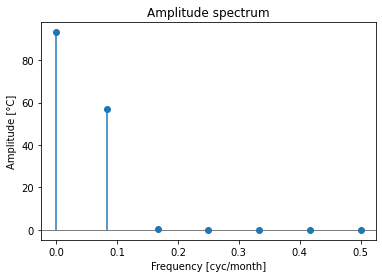

In [18]:
n = temps.size

# returns (n/2)+1 if n is even
# returns (n+1)/2 if odd
coef = np.fft.rfft(temps, norm='forward')

# if even, Nyquist coincides with last element of the array.
# if odd, all frequencies lie below Nyquist
if n % 2 == 0:
    coef[1:-1] = 2.0 * np.conj(coef[1:-1])
else:
    coef[1:] = 2.0 * np.conj(coef[1:])

# a[0] equals the mean
a, b = np.real(coef), np.imag(coef)

# return the frequencies.
f = np.fft.rfftfreq(temps.size, 1.0)

# Showing spectrum
spectrum = (a * a + b * b)

plt.axhline(0.0, color='k', lw=0.5)
plt.stem(f, spectrum, basefmt='None')
plt.xlabel('Frequency [cyc/month]'); plt.ylabel('Amplitude [°C]')
plt.title('Amplitude spectrum')
plt.show()

In [ ]:
# Custom function
def fourier_transform(yi):
    """
    EQUIVALENT TO fft.rfft
    
    a, b = fourier_transform(yi).
    Real-valued Fourier transform that determines the
    coefficients of the Fourier series for a given
    signal y. The coefficients of the cosine terms are
    returned in the array a; those of the sine terms
    in the array b. Frequencies start at zero and do
    not exceed the Nyquist frequency.
    yi     = {y1,y2,...,xn}
    """
    n = len(yi)
    
    a = np.zeros((n-1))
    b = np.zeros((n-1))

    # zero frequency
    a[0] = 1/n * np.sum(yi)

    b[0] = 0
    b[-1] = 0
    
    # if size is even
    if n % 2 == 0:
        m = int(n/2)
        
        for i in range(n):
            for j in range(1, m):
                # coefficient a_j
                a[j] += (yi[i] * np.cos(2 * np.pi * ((i * j) / n)))

                # coefficient b_j
                b[j] += (yi[i] * np.sin(2 * np.pi * ((i * j) / n)))


            # nyquist frequency
            a[-1] += (yi[i] * np.cos(np.pi * i))
            
        
        
        a[1:-1] *= 2/n
        b[1:-1] *= 2/n
        a[-1] *= 1/n
        
        return a, b
    else:
        m = (int((n-1)/2))
        for i in range(n):
            for j in range(1, m+1):
                a[j] += (yi[i] * np.cos(2 * np.pi * ((i * j) / n)))
                b[j] += (yi[i] * np.sin(2 * np.pi * ((i * j) / n)))
                
        a[1:] *= 2/n
        b[1:] *= 2/n

        return a, b

**ii) Trigonometric regression**

General function:

$$
y(x) = Y + A \cdot \cos \left( 2 \pi f x - \varphi \right)
$$

that is characterized by

* a [frequency](https://en.wikipedia.org/wiki/Frequency) $f$

* an [amplitude](https://en.wikipedia.org/wiki/Amplitude) $A$

* a horizontal [phase](https://en.wikipedia.org/wiki/Phase_(waves)) shift $\varphi$

* a vertical shift or [bias](https://en.wikipedia.org/wiki/DC_bias) $Y$


In [20]:
def trig_curvefit(xi, yi, x, period):
    """y = trig_curvefit(xi, yi, x, period).
    Trigonometric curve fitting method that fits a sinusoid
    with a given period through data points {xi,yi},
    evaluated at arguments x.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    period = sinusoidal period
    """
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')

    f = 1/period

    xi = xi.astype('float64')
    yi = yi.astype('float64')

    X = np.vstack((np.ones(xi.size), np.cos(2 * np.pi * f * xi), np.sin(2 * np.pi * f * xi))).T

    M = X.T @ X
    v = X.T @ yi

    a = np.linalg.solve(M, v)

    y = a[0] + a[1] * np.cos(2 * np.pi * f * x) + a[2] * np.sin(2 * np.pi * f * x)
        
    return y

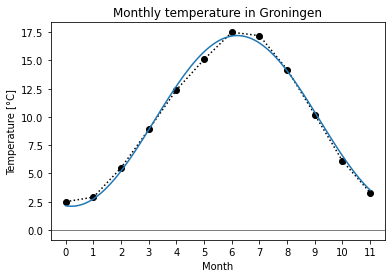

In [23]:
xi = np.arange(12)
yi = np.array([2.5,  2.9,  5.5,  8.9,  12.4, 15.1,
                  17.5, 17.2, 14.2, 10.2, 6.1,  3.3])

x = np.linspace(0, 11, 101)
y = trig_curvefit(xi, yi, x, 12)

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(xi, yi, 'o:k')
plt.plot(x, y)
plt.xlabel('Month'); plt.ylabel('Temperature [°C]')
plt.title('Monthly temperature in Groningen')
plt.xticks(months)
plt.show()

**iii) Discrete Cosine Transform**

The fourier transform is sensitive to sudden jumps, because of **Gibb's phenomenon**. Thus, use discrete cosine transform.

Only the cosine terms in a Fourier series are even function.

$$
A_i = \sqrt{a_i^2} = |a_i|
$$


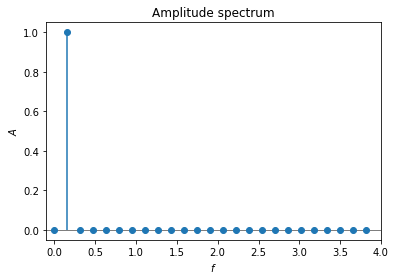

In [25]:
from scipy.fft import dct

x = np.arange(25) * np.pi / 24.0
y = np.cos(x)

# if even
a = dct(y, norm='forward', type=1)
a[1:-1] *= 2.0

def dctfreq(n, d=1.0):
    """Return the Discrete Cosine Transform sample frequencies.
    For information about parameters and return values, please
    consult help(rfftfreq).
    """
    return np.fft.rfftfreq(2 * (n - 1), d)

f = dctfreq(len(x), np.pi / 24.0)
spectrum = np.abs(a)

plt.axhline(0.0, color='k', lw=0.5)
plt.stem(f, spectrum, basefmt='None')
plt.xlabel('$f$'); plt.ylabel('$A$')
plt.title('Amplitude spectrum')
plt.axis((-0.1, 4.0, -0.05, 1.05))
plt.show()

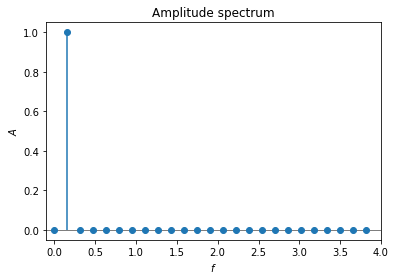

In [26]:
# Custom
def cosine_transform(yi):
    """a = cosine_transform(yi).
    Type-I discrete cosine transform that determines
    the coefficients of the cosine series for a given
    signal y. The coefficients are returned in the
    array a. Frequencies start at zero and end at the
    Nyquist frequency.
    yi     = {y1,y2,...,xn}
    """
    # extend the signal 
    y_extended = np.concatenate((yi[:-1], yi[:0:-1]))
    # retrieve coeficients 
    coeficients_a_b = np.fft.rfft(y_extended, norm='forward')
    # multiply all coeficients except the first and last. (number of samples is always even)
    coeficients_a_b[1:-1] = 2.0 * np.conj(coeficients_a_b[1:-1])
    # obtain only the a coeficients
    a_coeficients = np.real(coeficients_a_b)

    return a_coeficients

x = np.arange(25) * np.pi / 24.0
y = np.cos(x)

a = cosine_transform(y)
n = y.size

f = np.fft.rfftfreq(2 * (n-1), np.pi/24.0)
spectrum = np.abs(a)

plt.axhline(0.0, color='k', lw=0.5)
plt.stem(f, spectrum, basefmt='None')
plt.xlabel('$f$'); plt.ylabel('$A$')
plt.title('Amplitude spectrum')
plt.axis((-0.1, 4.0, -0.05, 1.05))
plt.show()

#### iv) Fourier filtering
A filter removes unwanted features from a function. This is done in the frequency domain.

Use `np.irfft()` to reconstruct the original signal.

`scipy.fft.idct(..., type=1)`

In [ ]:
def obtain_amplitude_values(y_values, sampling_period = 1):
    '''
    this function takes an array of y values (sampled from a signal)
    
    y_values: array-like shape containing sampled values
    
    sampling_period: period of sampling
    
    returns: 
                frequencies: array of frequencies obtained from fourier transform
                
                spectrum   : array of amplitudes correlation to the frequencies

    '''
    # obtain the coeficients using fast fourier transform
    coef = np.fft.rfft(y_values, norm='forward')
    
    # correct for shortcomings by multiplying values by 2 and taking the complex conjugate
    if len(y_values) % 2 == 0:
        coef[1:-1] = 2.0 * np.conj(coef[1:-1])
    else:
        coef[1:] = 2.0 * np.conj(coef[1:])
    # obtain a and b from coeficients
    a, b = np.real(coef), np.imag(coef)
    
    # obtain frequencies from fourier transfrom
    frequencies = np.fft.rfftfreq(len(y_values), sampling_period)
    
    # obtain the amplitude corresponding to a frequency
    spectrum = np.sqrt(a * a + b * b)
    
    return frequencies, spectrum

def plot_amplitude_spectrum(frequencies, amplitudes, name = None, xlim = None, ylim = None):
    '''
    make stemplot using the frequencies and their corresponding amplitude spectrum.
    
    frequencies: array with frequencies obtained by fft
    
    amplitudes: array with amplitudes obtained by fft
    
    name: string containing name to be added above the plot next to 'Amplitude spectrum'
    
    xlim: list of values in between which the x-axis is to be limited i.e. ([0, 10])
    '''
    title = 'Amplitude spectrum '
    if name:
        title = title + name
    plt.axhline(0.0, color='k', lw=0.5)
    plt.stem(frequencies, amplitudes, basefmt='None')
    plt.xlabel('Frequency'); plt.ylabel('Amplitude')
    plt.title(title); plt.xlim(xlim); plt.ylim(ylim)
    plt.show()
    return()

def my_inverse_fft(yi, f_max = None, f_min = None,kind = 'low', sampling_period = 1):
    '''
    yi = array of y values
    
    f_max = max cut off frequency
    
    f_min = min cut off frequency
    
    kind = ['low']/'high'/'stop'/'pass' 
            > low = low-pass filter
            > high = high-pass filter
            > stop = band-stop filter
            > pass = band-pass filter
    
    sampling_period = space between measurements on the x-axis 
    
    return: filtered y values
    '''

    if kind == 'pass' and f_max == None or kind == 'pass' and f_min == None:
        raise ValueError('please fill in both f_max and f_min')
    if kind == 'stop' and f_max == None or kind == 'stop' and f_min == None:
        raise ValueError('please fill in both f_max and f_min')
    if kind == 'low' and f_max == None:
        raise ValueError('you should select a f_max')
#         f_max = f_min
    if kind == 'high' and f_min == None:
        raise ValueError('You should select a f_min')
#         f_min = f_max
    
    # obtain frequencies and coeficients 
    coef = np.fft.rfft(yi, norm='forward')
    # check for even number of samples (Fny is last entry in array)
    if yi.size % 2 == 0:
        coef[1:-1] = 2.0 * np.conj(coef[1:-1])
    
    # check for odd number of samples, no Fny in the array
    elif yi.size % 2 == 1:
        coef[1::] = 2.0 * np.conj(coef[1::])
    # obtain alpha and beta
    a, b = np.real(coef), np.imag(coef)
    # obtain the frequencies corresponding to the amplitudes.
    frequencies = np.fft.rfftfreq(yi.size, sampling_period)
    spectrum_ori = np.sqrt(a * a + b * b)
    
    if kind == 'low': # filter out high frequencies
        a *= (frequencies < f_max); b *= (frequencies < f_max)

    elif kind == 'high': # filter out low frequencies
        a *= (frequencies > f_min); b *= (frequencies > f_min)
    elif kind == 'pass':
        a *= (frequencies < f_max)
        a *= (frequencies > f_min)

        b *= (frequencies < f_max)
        b *= (frequencies > f_min)
    elif kind == 'stop':
        a *= (frequencies < f_min)
        a *= (frequencies > f_max)

        b *= (frequencies < f_min)
        b *= (frequencies > f_max)
        
    # reconstruct the 'one' complex coeficient number
    coef_filtered = a + 1j * b
    
    if yi.size % 2 == 0:
        coef_filtered[1:-1] = 0.5 * np.conj(coef_filtered[1:-1])
    
    # check for odd number of samples, no Fny in the array
    elif yi.size % 2 == 1:
        coef_filtered[1::] = 0.5 * np.conj(coef_filtered[1::])
    
    filtered_y = np.fft.irfft(coef_filtered, norm='forward')
    
    return filtered_y
    

In [ ]:
# Corresponding frequency domain
# n = odd
coef = np.fft.rfft(y, norm='forward')
coef[1:] = 2.0 * np.conj(coef[1:])
a, b = np.real(coef), np.imag(coef)
spectrum = np.sqrt(a*a + b*b)
f = np.fft.rfftfreq(y.size, ts)

# 2) filtering

# band-stop filter
a *= (f < 49.9) | (f > 50.2)
b *= (f < 49.9) | (f > 50.2)

fmin = 1
a *= (f > fmin)
b *= (f > fmin)


# 3) Reconstruct (from frequency to time domain)
spectrum = np.sqrt(a*a + b*b)
coef = a + 1j * b
coef[1:] = np.conj(coef[1:]) / 2
cleaned = np.fft.irfft(coef, n=n, norm='forward')

#### v) Fourier Interpolation
The lowest non-zero frequency always corresponds with one cycle across the entire signal, i.e. $f_1 = \frac{1}{L}$. Therefore, $\Delta f=\frac{1}{L}$.


$
L = \frac{1}{\Delta f}$ <-> $\Delta f \cdot L = 1$

Therefore:

* A more *extensive* sampling corresponds with a *denser* spectrum

Duality between time and frequency domains:
$$
t_s \cdot f_\text{Ny} = \frac{1}{2}
$$

$$
\Delta f \cdot L = 1
$$

The same can be achieved with the type-I discrete cosine transform.

The result differs from the discrete Fourier transform in its assumptions about the boundary condition: Fourier transforms assume that a signal wraps around, whereas the cosine transform assumes the signal is extended by reflection.

`scipy.signal` contains `resample(original_data, desired_datapoints)`

In [30]:
def fourier_resample(yi, n):
    """
    For cosine resample just replace np.fft.X with dct and idct
    from scipy.fft import dct, idct
    
    y = fourier_resample(yi, n).
    Fourier interpolation method that resamples a given
    signal yi to n new points. The first element of the
    returned signal y coincides with the first element
    of the provided signal yi.
    yi     = {y1,y2,...,xn}
    n      = desired number of points
    """
    coef = np.fft.rfft(yi, norm='forward')
    # coef = dct(yi, type=1, norm='forward')
    if yi.size % 2 == 0:
        coef[1:-1] *= 2.0
    else:
        coef[1:] *= 2.0
    if n > yi.size:
        coef = np.concatenate((coef, np.zeros(n - yi.size)))
    else:
        coef = coef[:n // 2 + 1]
    if n % 2 == 0:
        coef[1:-1] /= 2.0
    else:
        coef[1:] /= 2.0
    y = np.fft.irfft(coef, n, norm='forward')
    # y = idct(coef, type=1, n=n, norm='forward')
    return y

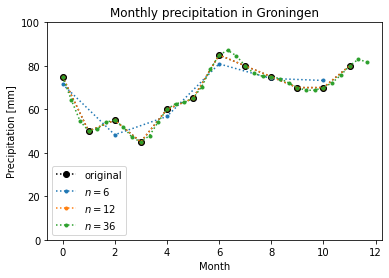

In [35]:
from scipy.signal import resample

n = 12
xi = np.arange(n)
yi = np.array([75, 50, 55, 45, 60, 65, 85, 80, 75, 70, 70, 80])

plt.plot(xi, yi, ':ok', label='original')

samples = [6, 12, 36]
scalars = [0.5, 1, 3]
for sample, scalar in zip(samples, scalars):  
    x = np.arange(n*scalar) / scalar
#     y = fourier_resample(yi, sample)
    y = resample(yi, sample)
    plt.plot(x, y, ':o', label=f'$n={sample}$', markersize=3)
    
plt.title('Monthly precipitation in Groningen')
plt.xlabel('Month')
plt.ylabel('Precipitation [mm]')

plt.ylim([0, 100])

plt.legend()
plt.show()

#### vi) Fourier Smoothing
Therefore, a promising approach to reduce measurement noise is to [smoothen](https://en.wikipedia.org/wiki/Smoothing) the signal by applying low-pass filtering.

In [ ]:
def fourier_smooth(yi, d, fmax, shape='boxcar'):
    """y = fourier_smooth(yi, d, fmax, shape='boxcar').
    Smoothing function that low-pass filters a signal
    yi with sampling time d. Spectral components with
    frequencies above a cut-off fmax are blocked, while
    lower frequencies are multiplied with a transfer
    function with a given shape.
    yi     = {y1,y2,...,xn}
    d      = sampling time
    fmax   = low-pass cut-off frequency
    shape  = transfer function shape (default 'boxcar')
    """
    from scipy.signal import get_window
    
    # spectrum = coeficients a and b
    spectrum = np.fft.rfft(yi, norm='forward')
    
    # width of the window
    width = int(fmax * yi.size * d) + 1
    
    # create array full of zero's the same size as the yi array
    transfer = np.zeros(spectrum.size)
    
    try:
        window = get_window(shape, 2 * width - 1, False)
    except:
        print('cannot run this shape')
        window = get_window('boxcar', 2 * width - 1, False)
    
    # fill the transfer function from 0 to width with the window values
    transfer[:width] = window[width - 1:]
    
    # multiply the coefficients with the transfer function
    spectrum *= transfer
    y = np.fft.irfft(spectrum, yi.size, norm='forward')
        
    return y

In [ ]:
new_y = fourier_smooth(y, d = sampling_freq, fmax = fmax, shape='triangle')

#### vi) short-term Fourier Transform
**Chirp**: a signal that increases/decreases in frequency over time.

number of samples in $ w = \frac{w}{t_s} = \frac{1}{\Delta f * t_s}$

number of samples in $\Delta x = \frac{\Delta x}{t_s}$ or in scipy $\Delta X = (nperseg - noverlap) * t_s$

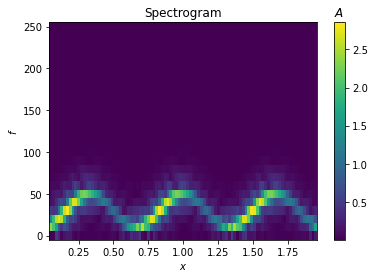

In [40]:
from scipy.signal import spectrogram

x = np.linspace(0.0, 2.0, 1000, endpoint=False)
totalphase = 2.0 * np.pi * np.cumsum(30.0 - 20.0 * np.cos(3.0 * np.pi * x)) * 2.0e-3
amplitude = 2.0 + np.sin(3.0 * np.pi * x)
y = amplitude * np.sin(totalphase)

L = 2.0
n = 1000
ts = L / n
fs = 1 / ts

coef = np.fft.rfft(y, n=n, norm='forward')
coef[1:-1] = 2.0 * np.conj(coef[1:-1])
a, b = np.real(coef), np.imag(coef)

spectrum = np.sqrt(a*a + b*b)
f = np.fft.rfftfreq(n, ts)

fss, xs, stft = spectrogram(
    y,
    fs=fs,
    nperseg=50,
    noverlap=40,
    window='tukey',
    detrend=False,
    scaling='spectrum',
    mode='magnitude'
)
stft[1:-1, :] *= 2.0

plt.pcolormesh(xs, fss, stft, shading='nearest')
plt.xlabel('$x$'); plt.ylabel('$f$')
plt.title('Spectrogram')
cbar = plt.colorbar(); cbar.ax.set_title('$A$')
plt.show()

# Misc

In [15]:
def P(n):
    """Square pyramidal numbers"""
    t = 0
    for k in range(n+1):
        t += k**2
        
    return t

def Fibonacci(n):
    """Fibonacci sequence"""
    if n < 0:
        print("Incorrect input")
    elif n == 0:
        return 0
    elif n == 1 or n == 2:
        return 1
 
    else:
        return Fibonacci(n-1) + Fibonacci(n-2)
    
def factorial(n):
    total = 1
    for k in range(1, n+1):
        total *= k
        
    return total

def C(n):
    """Catalan numbers"""
    if n == 0 or n == 1:
        return 1
    
    total = 1
    for k in range(2, n+1):
        total *= (n+k)/k
        
    return total
